In [1]:
import os
import re

from itertools import islice

from tqdm import tqdm, trange

import numpy as np
import pandas as pd

from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

# Deep learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda', index=0)

# Lectura y preprocesamiento

In [3]:
def colapsar_repeticion(match):
    elemento = match.groups()
    assert len(match.groups()) == 1
    return elemento[0]

def procesar_tweet(tweet):
    tweet = tweet.lower()
    regex_usuario = re.compile(r"@[\w\d]+")
    tweet = regex_usuario.sub("@usuario", tweet)
    
    regex_link = re.compile(r"\b(?:https?://|www\.)\S+\b")
    tweet = regex_link.sub("<link>", tweet)
    
    regex_frac = re.compile(r"\d+/\d+\w*")
    tweet = regex_frac.sub("<número>", tweet)
    
    regex_numbers = re.compile(r"\d+\w*")
    tweet = regex_numbers.sub("<número>", tweet)
    
    tokenizer = TweetTokenizer(reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    
    regex_collapse = re.compile(r"(\w)\1{2}")
    
    tokens = [regex_collapse.sub(colapsar_repeticion, token) for token in tokens]
    
    simbolos = r"""'@¡"#$%&'()*+,-./:;<=>¿[\]^_`{|}~'"""
    simbolos = set(simbolos) | set(["--->", "...", ". . .", ". .", ". ...", "..", "->"])
    tokens = [token for token in tokens if token not in simbolos]
    
    return tokens

In [4]:
df_train = pd.read_csv("../datos/training/EXIST2021_training.tsv", sep="\t")
df_train

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist
...,...,...,...,...,...,...,...
6972,EXIST2021,6973,twitter,es,"Estamos igual sin pareja, pero puedes besar a ...",non-sexist,non-sexist
6973,EXIST2021,6974,twitter,es,2020 hijo de re mil putas,non-sexist,non-sexist
6974,EXIST2021,6975,twitter,es,SEGURAMENTE ESTA CHICA NO COBRA EL DINERO QUE ...,non-sexist,non-sexist
6975,EXIST2021,6976,twitter,es,@safetyaitana mi madre dice q va fea y i agree,sexist,objectification


In [5]:
tweets = df_train["text"].apply(procesar_tweet)
labels1 = df_train["task1"].map({"sexist":1, "non-sexist":0}).values

# Train - test

In [6]:
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweets, labels1, test_size=0.2, random_state=42)

In [7]:
def get_vocab(tweets):
    tokens = [token for tweet in tweets for token in tweet]
    types = set(tokens) 
    vocab = {"<PAD>":0, "<UNK>":1}
    for i, word in enumerate(types, 2):
        vocab[word] = i
    return vocab


#########
vocab = get_vocab(train_tweets)
len(vocab)

22888

(array([1.151e+03, 1.423e+03, 1.148e+03, 1.118e+03, 1.363e+03, 6.970e+02,
        6.200e+01, 6.000e+00, 1.000e+00, 8.000e+00]),
 array([  2.,  12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92., 102.]),
 <BarContainer object of 10 artists>)

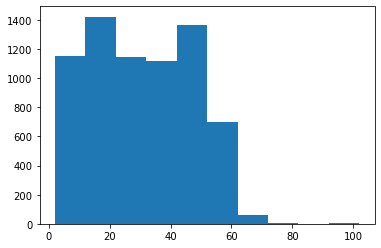

In [8]:
lens = [len(tweet) for tweet in tweets]
maxlen = max(lens)
plt.hist(lens)

In [9]:
class sEXIST2021Dataset:
    def __init__(self, tweets, labels, vocab, maxlen=None):
        self.tweets = tweets
        self.labels = labels
        self.vocab = vocab
        
        if not maxlen:
            lens = [len(tweet) for tweet in tweets]
            maxlen = max(lens)
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        tweet = self.tweets.iloc[idx]
        label = self.labels[idx]
        
        tweet_encoded = [self.vocab.get(token, 1) for token in tweet]
        x = torch.tensor(tweet_encoded, dtype=torch.int)
#         x = torch.zeros(self.maxlen, dtype=torch.int)
#         for i, token in enumerate(tweet[:self.maxlen]):
#             x[i] = self.vocab.get(token, 1) # 1 es para tokens desconocidos
            
        y = float(label)
        
        return x,y

    
def crear_batch(batch):
    """ Función para crear el batch del dataloader
    Parámetros
    ----------
    batch: lista de 2-tuplas
        El primer elemento corresponde al tensor del tweet
        y el segundo a la etiqueta (como flotante)
        
    Regresa:
    ---------
    2-tupla
        El primer elemento es el tensor con los tweets rellenados
        a la secuencia más larga del batch, y el segundo elemento es 
        un tensor con las etiquetas correspondientes
    """
    batch_size = len(batch)
    tweets, etiquetas = list(zip(*batch))
    
    # Creando el tensor de tweets
    lens = [len(tweet) for tweet in tweets]
    maxlen = max(lens)
    X = pad_sequence(tweets, batch_first=True)
    
    # Creando tensor de etiquetas
    y = torch.tensor(etiquetas).view(-1,1)
    
    return X, y, lens
    
#### Creación de datasets ####
train_dataset = sEXIST2021Dataset(train_tweets, train_labels, vocab, maxlen)
test_dataset = sEXIST2021Dataset(test_tweets, test_labels, vocab, maxlen)

train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=crear_batch)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=crear_batch)

In [10]:
def save_check_point(model, epoch, filename):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        },
        filename
    )

def train_epoch(model, dataloader, optimizer):
    for x, y_true, lens in dataloader:
        x, y_true = x.to(dev), y_true.to(dev)
        
        y_lgts = model(x, lens) # logits
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def eval_epoch(model, dataloader, num_batches=None):
    with torch.no_grad():
        # historiales
        losses, accs = [], []
        
        # si num_batches = None, es todo
        for x, y_true, lens in islice(dataloader, num_batches):
            x, y_true = x.to(dev), y_true.to(dev)

            y_lgts = model(x, lens)  # logits
            
            # predicción
            y_prob = torch.sigmoid(y_lgts)
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses)
        acc = np.mean(accs)

        return loss, acc
    
    
def train(model, train_dataloader, test_dataloader, 
          epochs=15, lr=1e-3, num_batches=None, checkname=""):

    # historiales
    loss_hist, acc_hist = {"train":[], "test":[]}, {"train":[], "test":[]}
    
    # optimizador
    #opt = optim.SGD(model.parameters(), lr=lr)
    opt = optim.Adam(model.parameters(), lr=lr)
    
    # ciclo de entrenamiento
    best_acc = 0
    for epoch in trange(epochs):

        # entrenamos la época
        model.train()
        train_epoch(model, train_dataloader, opt)

        # evaluamos la época en entrenamiento
        model.eval()
        train_loss, train_acc = eval_epoch(model, train_dataloader, num_batches)
        test_loss, test_acc = eval_epoch(model, test_dataloader, num_batches)

        # guardamos historial
        loss_hist["train"].append(train_loss)
        loss_hist["test"].append(test_loss)
        acc_hist["train"].append(train_acc)
        acc_hist["test"].append(test_acc)
        
        # si hay mejora guardamos punto de control
        if checkname and test_acc > best_acc:
            best_acc = test_acc
            save_check_point(model, epoch, checkname)

    return loss_hist, acc_hist


def plot_hist(loss_hist, acc_hist, title=""):
    fig, ax = plt.subplots(ncols=2, figsize=(16,9))
    for i, hist in enumerate([loss_hist, acc_hist]):
        ax[i].plot(hist["train"], label="train")
        ax[i].plot(hist["test"], label="test")
        ax[i].legend()
        ax[i].set_xlabel("epoch")
        
    ax[0].set_title("loss")
    ax[1].set_title("accuracy")
    fig.suptitle(title)
    
    return fig

def plot(loss_hist, acc_hist, c="#8bc34a", name = None):
    trn_loss, tst_loss = loss_hist["train"], loss_hist["test"]
    trn_acc, tst_acc = acc_hist["train"], acc_hist["test"]
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    
    epocas = np.arange(1, len(trn_loss)+1)
    ax[0].plot(epocas, trn_loss, 'tab:orange', label='trn loss')
    ax[0].plot(epocas, tst_loss, 'tab:red', label='tst loss')
    ax[0].set_title("Pérdidas", fontsize = 30, color = c)
    ax[1].plot(epocas, trn_acc, 'tab:green', label='trn acc')
    ax[1].plot(epocas, tst_acc, 'tab:blue', label='tst acc')
    ax[1].set_title("Exactitud", fontsize = 30, color = c)
    for i in range(2):
        ax[i].set_xlabel('época', fontsize = 25, color = c)
        ylabel = "pérdida" if i == 0 else "exactitud"
        ax[i].set_ylabel(ylabel, fontsize = 25, color = c)
        ax[i].legend(loc='upper left')
        ax[i].spines["left"].set_color(c)
        ax[i].spines["bottom"].set_color(c)
        yt = ax[i].get_yticks()
        #ax[i].set_yticklabels(yt, color = c, fontsize = 15)
        xt = ax[i].get_xticks()
        # ax[i].set_xticks(xt)
        #ax[i].set_xticklabels(xt, color = c, fontsize = 15)
        ax[i].tick_params(axis='both', labelsize=20, color=c, labelcolor=c)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)
    if name:
        fig.savefig(f"../figs/{name}.png", transparent = True, bbox_inches = "tight")
    

In [11]:
class EXISTRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, 
                 hidden_dim, num_layers=1):
        super().__init__()
        padding_idx = 0
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, 
                                      padding_idx=padding_idx)
        
        self.recurrente = nn.GRU(embedding_dim, hidden_dim, batch_first=True, 
                            num_layers=num_layers, dropout=0.2)

#         self.clf = nn.Sequential(
#             nn.BatchNorm1d(hidden_dim),
#             nn.Linear(hidden_dim, 1)
#         )
        self.clf = nn.Linear(hidden_dim, 1)
    
    
    def forward(self, x, lens):
        embeds = self.embedding(x)  # [N, seq_len] -> [N, seq_len, embedding_dim]
        embeds_packed = pack_padded_sequence(embeds, lens, 
                                             batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.recurrente(embeds_packed) # lstm_out también es PackedSequence
        out_padded, out_lengths = pad_packed_sequence(lstm_out, batch_first=True) # [N, seq_len, hidden_size], [N]
        out_padded, out_lengths = out_padded.to(dev), out_lengths.to(dev)
        # X_fc = torch.sum(out_padded, dim=1)/out_lengths.view(-1,1) # [N, hidden_size]
        # [N, hidden_size]
        X_fc = torch.stack([out_padded[i, seq_len-1, :] 
                            for i, seq_len in enumerate(out_lengths)])
        #X_fc = X_fc.flatten(1) # [N, hidden_size]
        y = self.clf(X_fc)
        return y

In [12]:
rnn_model = EXISTRNN(vocab_size=len(vocab), embedding_dim=512, 
                       hidden_dim=256, num_layers=2).to(dev)
rnn_model

EXISTRNN(
  (embedding): Embedding(22888, 512, padding_idx=0)
  (recurrente): GRU(512, 256, num_layers=2, batch_first=True, dropout=0.2)
  (clf): Linear(in_features=256, out_features=1, bias=True)
)

100%|██████████| 10/10 [02:23<00:00, 14.32s/it]


(2.0467916346145008, 0.6740687679083095)

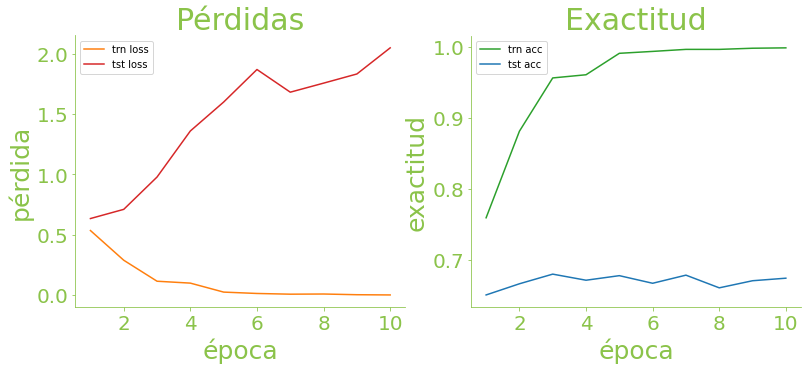

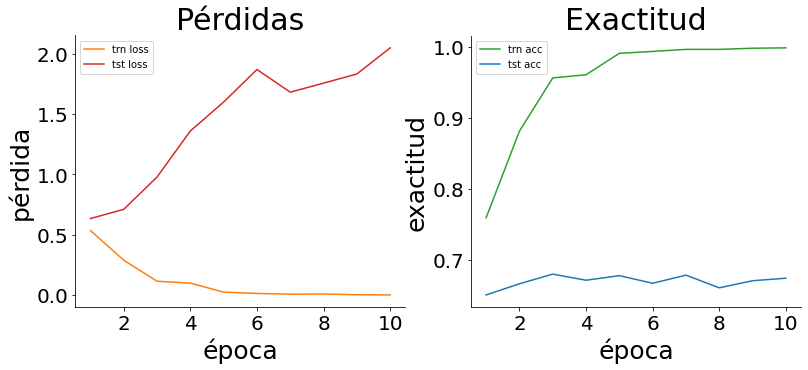

In [13]:
loss_hist, acc_hist = train(rnn_model, train_dataloader, test_dataloader, 
                            epochs=10, lr=1e-3, 
                            checkname="../checkpoints/rnn_weights.pth")

plot(loss_hist, acc_hist, name="RNN3-slide")
plot(loss_hist, acc_hist, c="black", name="RNN3-doc")
loss_hist["test"][-1], acc_hist["test"][-1]